In [ ]:
Xt = #your X data
y = #your y data
# models and metrics
import xgboost as xgb
from sklearn.model_selection import train_test_split
from xgbse.metrics import concordance_index
from xgbse.non_parametric import get_time_bins
from xgbse import (
    XGBSEKaplanNeighbors,
    XGBSEKaplanTree,
    XGBSEDebiasedBCE,
    XGBSEBootstrapEstimator
)
from xgbse.converters import (
    convert_data_to_xgb_format,
    convert_to_structured
)

# better plots
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
plt.style.use('bmh')

# setting seed
np.random.seed(42)

# to easily plot confidence intervals

def plot_ci(mean, upper_ci, lower_ci, i=42, title='Probability of survival $P(T \geq t)$'):
    
    # plotting mean and confidence intervals
    plt.figure(figsize=(12, 4), dpi=120)
    plt.plot(mean.columns,mean.iloc[i])
    plt.fill_between(mean.columns, lower_ci.iloc[i], upper_ci.iloc[i], alpha=0.2)

    plt.title(title)
    plt.xlabel('Time [days]')
    plt.ylabel('Probability')
    plt.tight_layout()

# to write data as markdown for publication

def df_to_markdown(df, float_format='%.2g'):
    """
    Export a pandas.DataFrame to markdown-formatted text.
    DataFrame should not contain any `|` characters.
    """
    from os import linesep
    df.columns = df.columns.astype(str)
    return linesep.join([
        '|'.join(df.columns),
        '|'.join(4 * '-' for i in df.columns),
        df.to_csv(sep='|', index=False, header=False, float_format=float_format)
    ]).replace('|', ' | ')

dtrain = xgb.DMatrix(Xt)
dtrain

## pre selected params for models ##

PARAMS_XGB_AFT = {
    'objective': 'survival:aft',
    'eval_metric': 'aft-nloglik',
    'aft_loss_distribution': 'normal',
    'aft_loss_distribution_scale': 1.0,
    'tree_method': 'hist', 
    'learning_rate': 5e-2, 
    'max_depth': 8, 
    'booster':'dart',
    'subsample':0.5,
    'min_child_weight': 50,
    'colsample_bynode':0.5
}

PARAMS_XGB_COX = {
    'objective': 'survival:cox',
    'tree_method': 'hist', 
    'learning_rate': 5e-2, 
    'max_depth': 8, 
    'booster':'dart',
    'subsample':0.5,
    'min_child_weight': 50, 
    'colsample_bynode':0.5
}

PARAMS_TREE = {
    'objective': 'survival:cox',
    'eval_metric': 'cox-nloglik',
    'tree_method': 'hist', 
    'max_depth': 100, 
    'booster':'dart', 
    'subsample': 1.0,
    'min_child_weight': 50, 
    'colsample_bynode': 1.0
}

PARAMS_LR = {
    'C': 1e-3,
    'max_iter': 500
}

N_NEIGHBORS = 50

TIME_BINS = np.arange(15, 315, 15)


C:\Users\marcel\AppData\Local\Temp/ipykernel_12704/2419616565.py:19: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('retina')


In [ ]:
# get X_train, X_test, y_train, y_test
(X_train, X_valid,
 y_train, y_valid) = \
train_test_split(Xt, y, test_size=0.2, random_state=42)

In [ ]:
dtrain = convert_data_to_xgb_format(X_train, y_train, 'survival:aft')
dval = convert_data_to_xgb_format(X_valid, y_valid, 'survival:aft')

# training model
bst = xgb.train(
    PARAMS_XGB_AFT,
    dtrain,
    num_boost_round=1000,
    early_stopping_rounds=10,
    evals=[(dval, 'val')],
    verbose_eval=0
)

# predicting and evaluating
preds = bst.predict(dval)
cind = concordance_index(y_valid, -preds, risk_strategy='precomputed')
print(f"C-index: {cind:.3f}")
print(f"Average survival time: {preds.mean():.0f} days")

C-index: 0.685
Average survival time: 11 days


In [ ]:
# saving predictions to plot later
preds_dict = {}

# loop to show different scale results
for scale in [1.0, 0.5, 0.25, 0.1]:
    
    # chaning parameter
    PARAMS_XGB_AFT['aft_loss_distribution_scale'] = scale
    
    # training model
    bst = xgb.train(
        PARAMS_XGB_AFT,
        dtrain,
        num_boost_round=1000,
        early_stopping_rounds=10,
        evals=[(dval, 'val')],
        verbose_eval=0
    )

    # predicting and evaluating
    preds = bst.predict(dval)
    cind = concordance_index(y_valid, -preds, risk_strategy='precomputed')

    preds_dict[scale] = preds

    print(f"aft_loss_distribution_scale: {scale}")
    print(f"C-index: {cind:.3f}")
    print(f"Average survival time: {preds.mean():.0f} days")
    print("----")

aft_loss_distribution_scale: 1.0
C-index: 0.685
Average survival time: 11 days
----
aft_loss_distribution_scale: 0.5
C-index: 0.689
Average survival time: 11 days
----
aft_loss_distribution_scale: 0.25
C-index: 0.689
Average survival time: 10 days
----
aft_loss_distribution_scale: 0.1
C-index: 0.681
Average survival time: 9 days
----


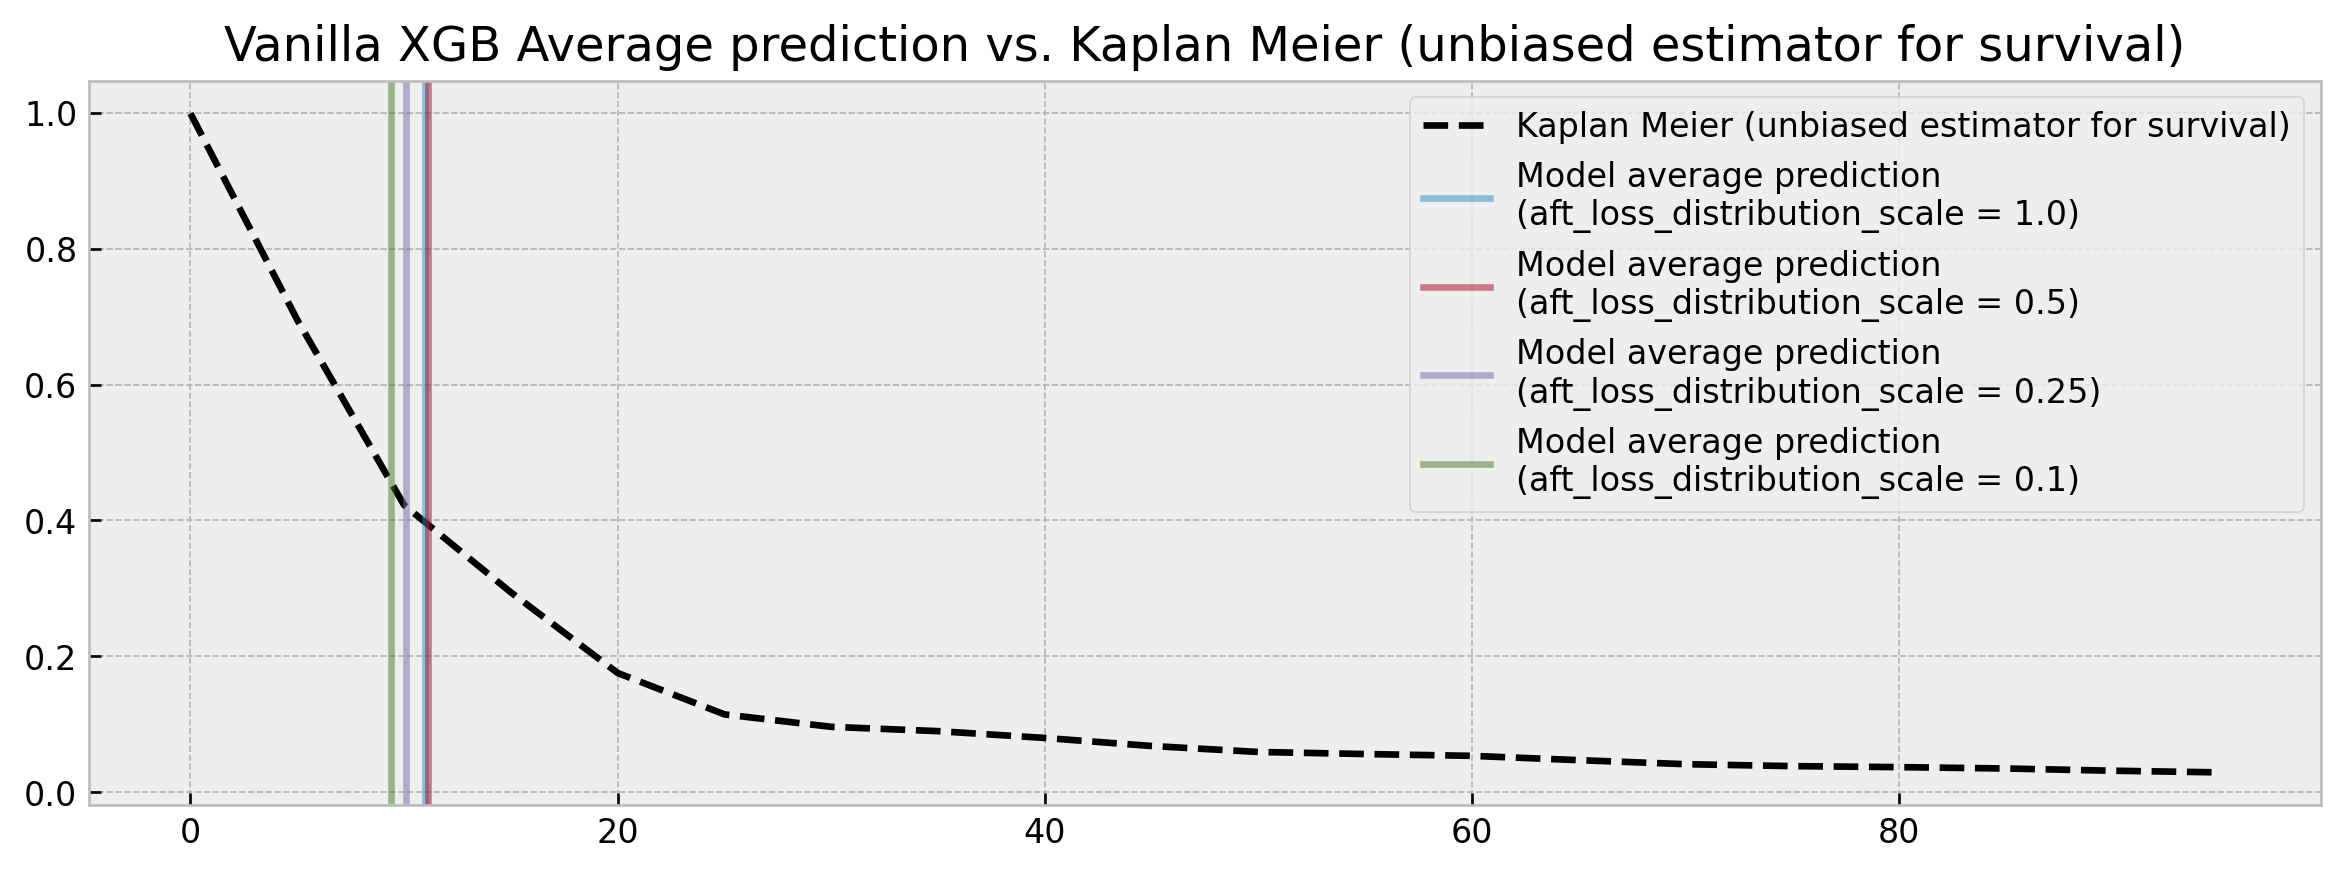

In [ ]:
from xgbse.non_parametric import calculate_kaplan_vectorized

TIME_BINS = np.arange(0, 100, 5)

mean, high, low = calculate_kaplan_vectorized(
    y['c2'].reshape(1,-1),
    y['c1'].reshape(1,-1),
    TIME_BINS
)

plt.figure(figsize=(12,4), dpi=120)
plt.plot(mean.columns, mean.iloc[0], 'k--', label='Kaplan Meier (unbiased estimator for survival)')

for i, scale in enumerate([1.0, 0.5, 0.25, 0.1]):
    plt.axvline(
        preds_dict[scale].mean(),
        label=f'Model average prediction\n(aft_loss_distribution_scale = {scale})',
        linewidth=2, 
        alpha=0.5,
        color=f'C{i}'
    )

plt.title('Vanilla XGB Average prediction vs. Kaplan Meier (unbiased estimator for survival)')
plt.legend()